In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix
from PIL import Image, UnidentifiedImageError
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



In [2]:
data_path = "C:\\Users\\serdi\\Desktop\\Flood_Detection_Final_Project"
class_names = ["Flood", "Not_Flood"]
X, y = [], []

for class_name in class_names:
    class_path = os.path.join(data_path, class_name)
    for image_path in os.listdir(class_path):
        try:
            img = load_img(os.path.join(class_path, image_path), target_size=(224, 224))
            img_array = img_to_array(img)
            X.append(img_array)
            y.append(0 if class_name == "Flood" else 1)
        except UnidentifiedImageError:
            print(f"Invalid image file: {os.path.join(class_path, image_path)}")


In [3]:
X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=42)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.25,
    zoom_range=0.3,
    channel_shift_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=[0.5, 1.5] 
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [4]:
model = Sequential()

# Block 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))

# Block 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten and Dense layers
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [5]:
optimizer = Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    filepath='best_weights.h5',
    monitor='val_loss',
    save_best_only=True
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32, shuffle=True)



In [6]:

history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=30,
validation_data=val_generator,
validation_steps=len(X_val) // 32,
callbacks=[early_stopping, model_checkpoint])

test_generator = test_datagen.flow(X_test, y_test, batch_size=32, shuffle=True)
y_pred_probs = model.predict(test_generator, steps=len(X_test) // 32)
y_pred = np.where(y_pred_probs > 0.5, 1, 0)

Epoch 1/30
104/104 [==============================] - 164s 2s/step - loss: 0.5922 - accuracy: 0.6970 - val_loss: 0.6057 - val_accuracy: 0.6994
Epoch 2/30
104/104 [==============================] - 121s 1s/step - loss: 0.5110 - accuracy: 0.7567 - val_loss: 0.5711 - val_accuracy: 0.7298
Epoch 3/30
104/104 [==============================] - 119s 1s/step - loss: 0.4614 - accuracy: 0.7907 - val_loss: 0.4674 - val_accuracy: 0.8107
Epoch 4/30
104/104 [==============================] - 132s 1s/step - loss: 0.4573 - accuracy: 0.7947 - val_loss: 0.4743 - val_accuracy: 0.7822
Epoch 5/30
104/104 [==============================] - 136s 1s/step - loss: 0.4359 - accuracy: 0.7977 - val_loss: 0.5193 - val_accuracy: 0.7693
Epoch 6/30
104/104 [==============================] - 126s 1s/step - loss: 0.4474 - accuracy: 0.7986 - val_loss: 0.6336 - val_accuracy: 0.7105
Epoch 7/30
104/104 [==============================] - 130s 1s/step - loss: 0.4174 - accuracy: 0.8250 - val_loss: 0.4232 - val_accuracy: 0.8281

In [7]:
test_acc = accuracy_score(y_test[:len(y_pred)], y_pred)
test_recall = recall_score(y_test[:len(y_pred)], y_pred)
test_f1 = f1_score(y_test[:len(y_pred)], y_pred)
conf_matrix = confusion_matrix(y_test[:len(y_pred)], y_pred)

In [8]:
print("Test Accuracy: {:.2f}%".format(test_acc * 100))
print("Recall: {:.2f}".format(test_recall))
print("F1 Score: {:.2f}".format(test_f1))
print("Confusion Matrix:\n", conf_matrix)

Test Accuracy: 52.39%
Recall: 0.63
F1 Score: 0.54
Confusion Matrix:
 [[269 341]
 [177 301]]


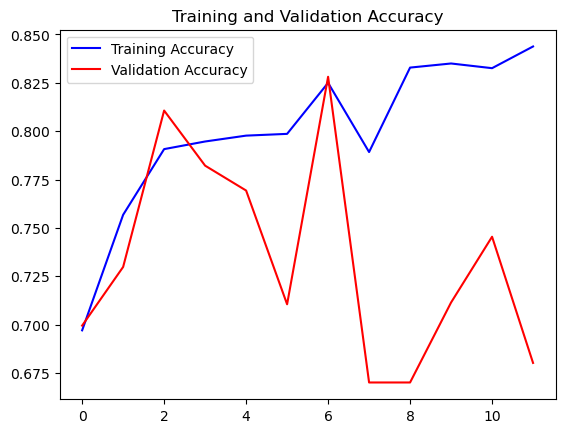

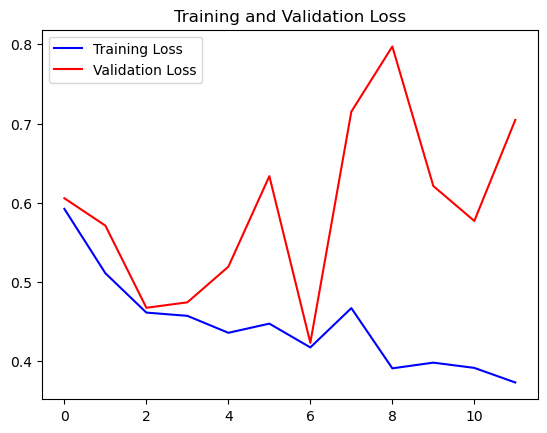

In [9]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_training_history(history)

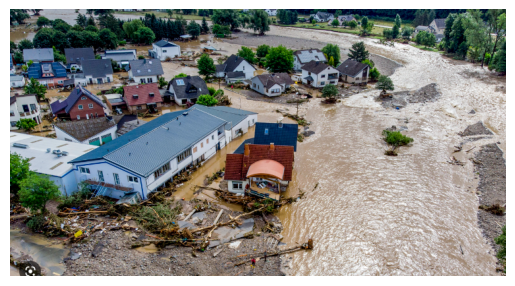

Prediction: Flood
Value: 0.9845


In [18]:
def predict_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0
    preds = model.predict(x)
    return preds[0][0]

new_image_path = "sel2.png"
prediction = predict_image(new_image_path)

img = load_img(new_image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

if prediction > 0.5:
    print("Prediction: Flood")
else:
    print("Prediction: Not Flood")

print("Value: {:.4f}".format(prediction))